In [1]:
using LinearAlgebra, CairoMakie, SparseArrays;

In [2]:
struct HermiteBeam
    n_nodes_::Int
    n_elements_::Int
    x_mesh_::Vector{Float64}
    h_::Float64
    e_s_::Float64
    inertia_::Float64
    q_::Float64
end

function HermiteBeam(n_nodes::Int, x_0::Float64, beam_length::Float64, e_s::Float64, inertia::Float64, q::Float64)
    h = beam_length / (n_nodes - 1);
    x_mesh = Vector(LinRange(x_0, x_0 + beam_length, n_nodes));
    return HermiteBeam(n_nodes, n_nodes-1, x_mesh, h, e_s, inertia, q);
end

HermiteBeam

In [3]:
function generateBeamFEM(hermite_beams::Vector{HermiteBeam})
    n_nodes = sum([hermite_beam.n_nodes_ for hermite_beam in hermite_beams]);
    n_nodes -= length(hermite_beams) - 1;
    stiffness_matrix = spzeros(2*n_nodes, 2*n_nodes);
    source_vector = zeros(2*n_nodes);
    for (i_beam, beam) in enumerate(hermite_beams)
        start_node_id = sum([b.n_nodes_ for b in hermite_beams[1:i_beam-1]]) - (i_beam - 1);
        h = beam.h_;
        part_stiffness_matrix = [
            12/h^3 6/h^2 -12/h^3 6/h^2;
            6/h^2 4/h -6/h^2 2/h;
            -12/h^3 -6/h^2 12/h^3 -6/h^2;
            6/h^2 2/h -6/h^2 4/h
        ] * beam.e_s_ * beam.inertia_;
        part_source_vector = [h/2, h^2/12, h/2, -h^2/12] * beam.q_;
        # insert part stiffness matrix to stiffness matrix
        # and part source vector to source vector
        for i_element = 1: beam.n_elements_
            stiffness_matrix[
                2*start_node_id + 2*i_element - 1: 2*start_node_id + 2*i_element + 2,
                2*start_node_id + 2*i_element - 1: 2*start_node_id + 2*i_element + 2
            ] .+= part_stiffness_matrix;
            source_vector[
                2*start_node_id + 2*i_element - 1: 2*start_node_id + 2*i_element + 2
            ] .+= part_source_vector;
        end
    end
    return stiffness_matrix, source_vector;
end

generateBeamFEM (generic function with 1 method)

In [27]:
e_s = 207e9;
d1 = 38.1e-3;
d2 = 50.8e-3;
j1 = pi/64 * d1^4;
j2 = pi/64 * d2^4;
l1 = 0.15;
l2 = 0.3;
l3 = 0.15;
n1 = 2;
n2 = 2;
n3 = 2;
q1 = 0.;
q2 = -35e3;
q3 = 0.;

beam1 = HermiteBeam(n1, 0., l1, e_s, j1, q1);
beam2 = HermiteBeam(n2, l1, l2, e_s, j2, q2);
beam3 = HermiteBeam(n3, l1+l2, l3, e_s, j1, q3);
beams = [beam1, beam2, beam3];

In [28]:
stiffness_matrix, source_vector = generateBeamFEM(beams);

In [29]:
stiffness_matrix

8×8 SparseMatrixCSC{Float64, Int64} with 40 stored entries:
  7.61286e7   5.70964e6  -7.61286e7  …    ⋅           ⋅           ⋅ 
  5.70964e6   5.70964e5  -5.70964e6       ⋅           ⋅           ⋅ 
 -7.61286e7  -5.70964e6   1.06204e8      4.51132e6    ⋅           ⋅ 
  5.70964e6   2.85482e5  -1.19832e6      4.51132e5    ⋅           ⋅ 
   ⋅           ⋅         -3.00755e7      1.19832e6  -7.61286e7   5.70964e6
   ⋅           ⋅          4.51132e6  …   1.47323e6  -5.70964e6   2.85482e5
   ⋅           ⋅           ⋅            -5.70964e6   7.61286e7  -5.70964e6
   ⋅           ⋅           ⋅             2.85482e5  -5.70964e6   5.70964e5

In [30]:
function solve(
    stiffness_matrix::SparseMatrixCSC, 
    source_vector::Vector, 
    known_nodes_ids::Vector,
    known_nodes_values::Vector
)::Vector
    @assert length(known_nodes_ids) == length(known_nodes_values);
    n_nodes = length(source_vector);
    solution_vector = zeros(n_nodes);
    solution_vector[known_nodes_ids] .= known_nodes_values;
    unknown_nodes_ids = setdiff(1:n_nodes, known_nodes_ids);
    part_stiffness_matrix = stiffness_matrix[unknown_nodes_ids, unknown_nodes_ids];
    part_source_vector = (source_vector .- stiffness_matrix * solution_vector)[unknown_nodes_ids];
    solution_vector[unknown_nodes_ids] .= part_stiffness_matrix \ part_source_vector;
    return solution_vector;
end

solve (generic function with 1 method)

In [31]:
known_nodes_ids = [1, 2, 7, 8];
known_nodes_values = [0., 0., 0., 0.];
solution_vector = solve(stiffness_matrix, source_vector, known_nodes_ids, known_nodes_values);

In [32]:
ws = solution_vector[1:2:end];
thetas = solution_vector[2:2:end];

In [39]:
ws

4-element Vector{Float64}:
  0.0
 -0.0001518398241320473
 -0.0001518398241320473
  0.0

In [41]:
thetas

4-element Vector{Float64}:
  0.0
 -0.0011050337605297248
  0.001105033760529725
  0.0

In [42]:
analyticalAngle(l1)

-0.0011050337605297276

In [43]:
analyticalDeflection(l1)

-0.00015183982413204648

In [33]:
function hermiteInterpolation(
    hermite_beams::Vector{HermiteBeam},
    ws::Vector,
    thetas::Vector,
    x::Float64
)
    for (i_beam, beam) in enumerate(hermite_beams)
        if x < beam.x_mesh_[1] || x > beam.x_mesh_[end]
            continue;
        else
            start_node_id = sum([b.n_nodes_ for b in hermite_beams[1:i_beam-1]]) - (i_beam - 1);
            w_beam = ws[start_node_id+1: start_node_id+beam.n_nodes_];
            theta_beam = thetas[start_node_id+1: start_node_id+beam.n_nodes_];
            if x in beam.x_mesh_
                index = findfirst(isequal(x), beam.x_mesh_);
                return w_beam[index], theta_beam[index];
            else
                index = findfirst(item->item > x, beam.x_mesh_);
                if index == 1
                    index = 2;
                end
                index -= 1;
                x1 = beam.x_mesh_[index];
                t = x - x1;
                h = beam.h_;
                w_theta = [w_beam[index], theta_beam[index], w_beam[index+1], theta_beam[index+1]];
                coeff1 = [
                    (h-t)^2 * (h + 2*t), t * (h-t)^2 * h, t^2 * (3*h - 2*t), t^2 * (t-h) * h
                ] ./ h^3;
                coeff2 = [
                    6 * t * (t-h), (h - 3*t) * (h - t) * h, 6 * t * (h-t), t * (3*t - 2*h) * h
                ] ./ h^3;
                return dot(coeff1, w_theta), dot(coeff2, w_theta);
            end
        end
    end
    return 0., 0.;
end

function hermiteInterpolation(
    hermite_beams::Vector{HermiteBeam},
    ws::Vector,
    thetas::Vector,
    x_mesh_minor::Vector
)
    theta_minor = similar(x_mesh_minor);
    w_minor = similar(x_mesh_minor);
    for (i, x) in enumerate(x_mesh_minor)
        w_minor[i], theta_minor[i] = hermiteInterpolation(hermite_beams, ws, thetas, x);
    end
    return w_minor, theta_minor;
end

hermiteInterpolation (generic function with 2 methods)

In [34]:
x_minor = Vector(LinRange(0., (l1+l2+l3)/2, 101));
w_minor, theta_minor = hermiteInterpolation(beams, ws, thetas, x_minor);

In [35]:
function analyticalAngle(x)
    out1 = ((x <= 0.15) ? (x .* (0.122599630386343 * x - 0.0257568362948163)) : (-0.0862028651153974 * x .^ 3 + 0.0775825786038577 * x .^ 2 - 0.013968317379196 * x - 0.000464459502472649))
    return out1
end

function analyticalDeflection(x)
    out1 = ((x <= 0.15) ? (x .^ 2 .* (0.0408665434621143 * x - 0.0128784181474081)) : (-0.0215507162788494 * x .^ 4 + 0.0258608595346192 * x .^ 3 - 0.00698415868959802 * x .^ 2 - 0.000464459502472649 * x - 1.39767905836677e-6))
    return out1
end

x_analytical = Vector(LinRange(0., (l1+l2+l3)/2, 11));
w_analytical = analyticalDeflection.(x_analytical);
theta_analytical = analyticalAngle.(x_analytical);

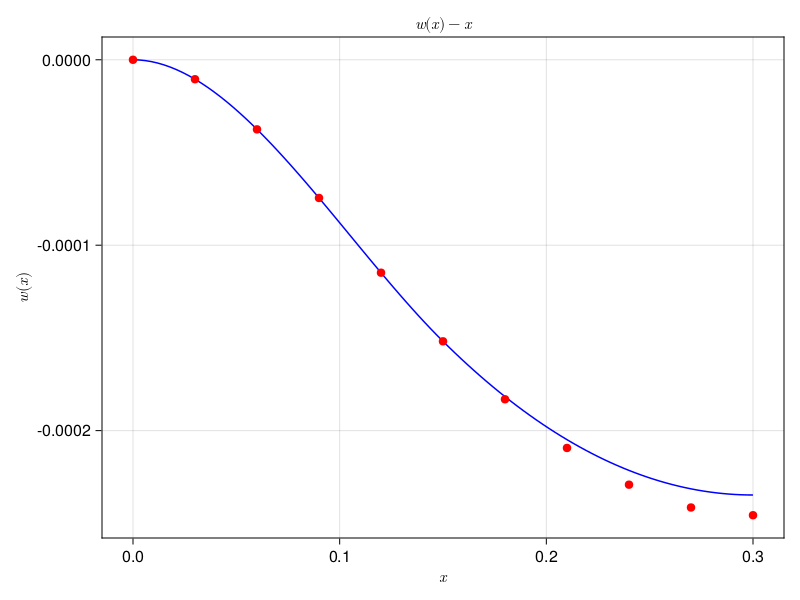

In [36]:
fig = Figure(resolution = (800, 600));
axes = Axis(fig[1, 1], xlabel = L"$x$", ylabel = L"$w(x)$", title = L"$w(x)-x$");
lines!(axes, x_minor, w_minor, color = :blue);
scatter!(axes, x_analytical, w_analytical, color = :red);
# save("w.png", fig);
fig

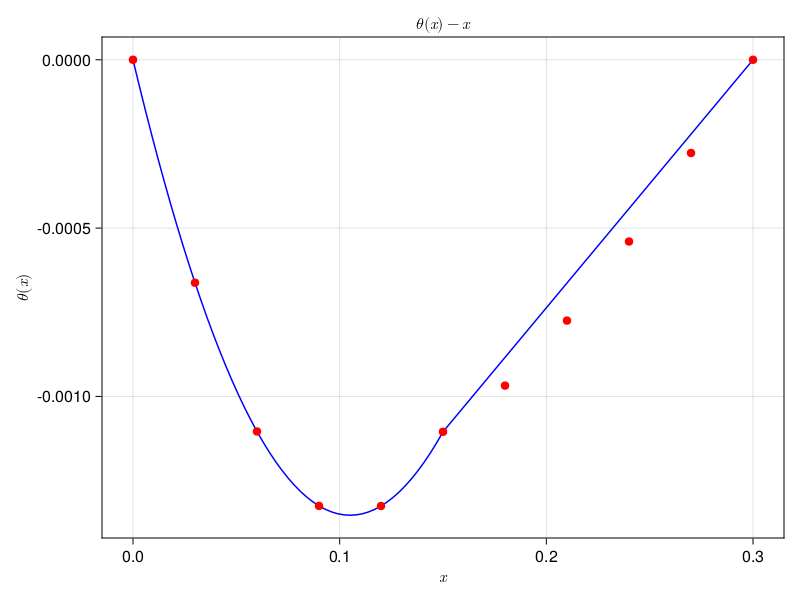

In [37]:
fig = Figure(resolution = (800, 600));
axes = Axis(fig[1, 1], xlabel = L"$x$", ylabel = L"$\theta(x)$", title = L"$\theta(x)-x$");
lines!(axes, x_minor, theta_minor, color = :blue);
scatter!(axes, x_analytical, theta_analytical, color = :red);
# save("theta.png", fig);
fig